# Data Analaysis

## Helpers

### Logging

In [1]:
import logging
from IPython.display import display, HTML, clear_output


class DisplayHandler(logging.Handler):
    def emit(self, record):
        message = self.format(record)
        display(message)


class HTMLFormatter(logging.Formatter):
    level_colors = {
        logging.DEBUG: 'lightblue',
        logging.INFO: 'dodgerblue',
        logging.WARNING: 'goldenrod',
        logging.ERROR: 'crimson',
        logging.CRITICAL: 'firebrick'
    }
    
    def __init__(self):
        super().__init__(
            '<span style="font-weight: bold; color: green">{asctime}</span> '
            '[<span style="font-weight: bold; color: {levelcolor}">{levelname}</span>] '
            '{message}',
            style='{'
        )
    
    def format(self, record):
        record.levelcolor = self.level_colors.get(record.levelno, 'black')
        return HTML(super().format(record))

In [2]:
log = logging.getLogger()
handler = DisplayHandler()
handler.setFormatter(HTMLFormatter())
log.addHandler(handler)
log.setLevel(logging.WARNING)

### Custom helpers

In [3]:
from helpers import *

## Global variables

In [4]:
data_dir = Path('../data')
figs_dir = Path('../figs')

## Dataset information

In [5]:
dataset = load_csv_dataset(data_dir.joinpath('dataset.csv'))

In [6]:
selected_issues = set((d['project'], d['issue_number']) for d in dataset if d['td_item'] and d['td_item'] != '-')

count_sections = len([d for d in dataset if (d['project'], d['issue_number']) in selected_issues])
count_included_sections = len([d for d in dataset if ((d['project'], d['issue_number']) in selected_issues) and d['td_item'] != '-'])

print("Number of collected sections:",count_sections)
print("Number of included sections:",count_included_sections)
print("Number of discarded sections:",count_sections-count_included_sections)

Number of collected sections: 534
Number of included sections: 508
Number of discarded sections: 26


Filter included sections (for RQs)

In [7]:
dataset = [d for d in dataset if d['td_item'] and d['td_item'] != '-']

In [8]:
len(set(d['td_item'] for d in dataset if len(d['fixing_commit'].split(',')) > 1))

7

## RQ1

### Issues Distribution

In [9]:
projects = sorted(list(set([d['project'] for d in dataset])))
tdtypes = sorted(list(set([d['classification'] for d in dataset])))

print(f'{"": <20}{projects}   TOTAL')
for t in tdtypes:
    sums = [len(set(d['issue_number'] for d in dataset if d['classification'] == t and d['project'] == p)) for p in projects]
    print(f'{t: <18}  {sums[0]: >7} {sums[1]: >9} {sums[2]: >8} {sums[3]: >9} {sums[4]: >9} {sum(sums): >9}')
sums = [len(set(d['issue_number'] for d in dataset if d['project'] == p)) for p in projects]
print(f'{"total": <18}  {sums[0]: >7} {sums[1]: >9} {sums[2]: >8} {sums[3]: >9} {sums[4]: >9} {sum(sums): >9}')

                    ['camel', 'hadoop', 'hbase', 'impala', 'thrift']   TOTAL
architecture_debt         8         3        2         2         3        18
code_debt                24        48       33        18        36       159
design_debt              28         8       33        25        27       121
test_debt                 7        10       13         9         7        46
total                    61        63       63        52        61       300


### TD items distribution

In [10]:
it = len(set([d['td_item'] for d in dataset]))
sc = len(set([d['td_item'] for d in dataset if d['is_fixed'] == 'yes']))
pc = sc/it * 100
print(f'{"TOTAL": <30} {it: >3} {sc: >3} {pc: >5.1f}%')

for t in tdtypes:
    it = len(set([d['td_item'] for d in dataset if d['classification'] == t]))
    sc = len(set([d['td_item'] for d in dataset if d['is_fixed'] == 'yes' and d['classification'] == t]))
    pc = sc/it * 100
    print(f'\n{t: <30} {it: >3} {sc: >3} {pc: >5.1f}%')

    subtype = sorted(list(set([d['indicator'] for d in dataset if d['classification'] == t])))
    for st in subtype:
        it = len(set([d['td_item'] for d in dataset if d['classification'] == t and d['indicator'] == st]))
        sc = len(set([d['td_item'] for d in dataset if d['is_fixed'] == 'yes' and d['classification'] == t and d['indicator'] == st]))
        pc = sc/it * 100
        print(f'{"": <5}{st: <25} {it: >3} {sc: >3} {pc: >5.1f}%')

TOTAL                          357 312  87.4%

architecture_debt               18  16  88.9%
     using_obsolete_technology   8   8 100.0%
     violation_of_modularity    10   8  80.0%

code_debt                      175 154  88.0%
     complex_code                2   0   0.0%
     dead_code                  24  20  83.3%
     duplicated_code             1   1 100.0%
     low_quality_code          126 115  91.3%
     multi-thread_correctness   10   9  90.0%
     slow_algorithm             17  14  82.4%

design_debt                    123 113  91.9%
     non-optimal_design        123 113  91.9%

test_debt                       47  35  74.5%
     expensive_tests             3   3 100.0%
     flaky_test                 11   7  63.6%
     lack_of_tests              21  15  71.4%
     low_coverage               12  10  83.3%


In [11]:
number_multitype_tditems = len(set((d['td_item'], d['classification']) for d in dataset)) - len(set(d['td_item'] for d in dataset))
print("Number of TD items with more than one TD type:", number_multitype_tditems)

Number of TD items with more than one TD type: 6


### Comparison of TD types

In [12]:
import scipy.stats as stats

tdtypes_ = set(tdtypes)
for t1 in tdtypes:
    tdtypes_.remove(t1)
    for t2 in tdtypes_:
        fischer_matrix = [
            [
                len(set(d['td_item'] for d in dataset if d['classification'] == t1 and d['is_fixed'] == 'yes')),
                len(set(d['td_item'] for d in dataset if d['classification'] == t1 and d['is_fixed'] == 'no'))
            ],
            [
                len(set(d['td_item'] for d in dataset if d['classification'] == t2 and d['is_fixed'] == 'yes')),
                len(set(d['td_item'] for d in dataset if d['classification'] == t2 and d['is_fixed'] == 'no'))
            ]
        ]
        
        ft = stats.fisher_exact(fischer_matrix)
        # sig = '*' if ft.pvalue < (0.05/6) else '' # Bonferroni
        sig = '*' if ft.pvalue < 0.05 else ''
        effect_size = (fischer_matrix[0][0]*fischer_matrix[1][1])/(fischer_matrix[1][0]*fischer_matrix[0][1])
        
        print(f"{t1: <18} x {t2: <13} {ft.statistic: <1.2f} {ft.pvalue: <1.4f}{sig: <1} {effect_size: <1.2}")

architecture_debt  x test_debt     2.74 0.3158  2.7
architecture_debt  x code_debt     1.09 1.0000  1.1
architecture_debt  x design_debt   0.64 0.6341  0.64
code_debt          x test_debt     2.51 0.0351* 2.5
code_debt          x design_debt   0.58 0.2415  0.58
design_debt        x test_debt     4.30 0.0031* 4.3


### Comparison of projects

In [13]:
it = len(set([d['td_item'] for d in dataset]))
sc = len(set([d['td_item'] for d in dataset if d['is_fixed'] == 'yes']))
pc = sc/it * 100
print(f'{"TOTAL": <7} {it: >3} {sc: >3} {pc: >5.1f}%')

for p in projects:
    it = len(set([d['td_item'] for d in dataset if d['project'] == p]))
    sc = len(set([d['td_item'] for d in dataset if d['is_fixed'] == 'yes' and d['project'] == p]))
    pc = sc/it * 100
    print(f'{p: <7} {it: >3} {sc: >3} {pc: >5.1f}%')

TOTAL   357 312  87.4%
camel    67  62  92.5%
hadoop   79  61  77.2%
hbase    81  70  86.4%
impala   54  52  96.3%
thrift   76  67  88.2%


In [14]:
import scipy.stats as stats

projects_ = set(projects)
for p1 in projects:
    projects_.remove(p1)
    for p2 in projects_:
        fischer_matrix = [
            [
                len(set(d['td_item'] for d in dataset if d['project'] == p1 and d['is_fixed'] == 'yes')),
                len(set(d['td_item'] for d in dataset if d['project'] == p1 and d['is_fixed'] == 'no'))
            ],
            [
                len(set(d['td_item'] for d in dataset if d['project'] == p2 and d['is_fixed'] == 'yes')),
                len(set(d['td_item'] for d in dataset if d['project'] == p2 and d['is_fixed'] == 'no'))
            ]
        ]
        
        ft = stats.fisher_exact(fischer_matrix)
        # sig = '*' if ft.pvalue < (0.05/10) else '' # bonferroni
        sig = '*' if ft.pvalue < 0.05 else ''
        effect_size = (fischer_matrix[0][0]*fischer_matrix[1][1])/(fischer_matrix[1][0]*fischer_matrix[0][1])
        
        print(f"{p1: <6} x {p2: <6} {ft.statistic: <1.2f} {ft.pvalue: <1.3f}{sig: <1} {effect_size: <1.2}")

camel  x impala 0.48 0.459  0.48
camel  x thrift 1.48 0.571  1.5
camel  x hbase  1.95 0.293  1.9
camel  x hadoop 3.66 0.012* 3.7
hadoop x impala 0.13 0.002* 0.13
hadoop x thrift 0.40 0.054  0.4
hadoop x hbase  0.53 0.153  0.53
hbase  x impala 0.24 0.075  0.24
hbase  x thrift 0.76 0.631  0.76
impala x thrift 3.10 0.191  3.1


## RQ2

In [15]:
import matplotlib.pyplot as plt
import numpy as np

df_rq2 = []
for d in dataset:
    if d['is_fixed'] == 'yes' and not [e for e in df_rq2 if e['td_item'] == d['td_item']]:
        df_rq2.append({
            'td_item': d['td_item'],
            'td_type': d['classification'],
            'project': d['project'],
            'identification_latency': d['identification_latency'],
            'discussion_period': d['discussion_period'],
            'remediation_latency': d['remediation_latency'],
            'remediation_latency_without_discussion': d['remediation_latency_without_discussion'] if d['remediation_latency'] == 'unknown' else 'unknown'
        })

save_csv_dataset(data_dir.joinpath('rq2-intervals.csv'), df_rq2)

In [16]:
periods = {
    'identification_latency': 'Identification Latency',
    'discussion_period': 'Discussion Period',
    'remediation_latency': 'Remediation Latency',
    'remediation_latency_without_discussion': 'Remediation Latency\n(w/o discussion)'
}

td_types = {
    'architecture_debt': 'Architecture',
    'code_debt': 'Code',
    'design_debt': 'Design',
    'test_debt': 'Test'
}

### Compare Latencies

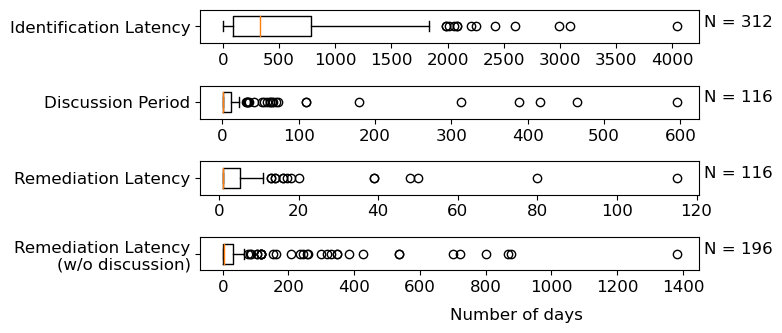

In [17]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(4,1, figsize=(8,4))
for i, col in enumerate(periods):
    data = [int(d[col]) for d in df_rq2 if d[col] != 'unknown']
    ax[i].boxplot(data, widths=0.6, vert=False)
    ax[i].set_yticklabels([periods[col]])
    ax[i].text(max(data)*1.06,1,f'N = {len(data)}')

plt.text(max(data)/2,-1,f'Number of days')

fig.tight_layout()
plt.show()

fig.savefig(figs_dir.joinpath("rq2-intervals.pdf"), bbox_inches='tight')

In [18]:
from statistics import median
from scipy import stats
import scikit_posthocs as sp

groups = {p: [int(d[p]) for d in df_rq2 if d[p] != 'unknown'] for p in periods}
for p, data in groups.items():
    print(f"Median {p}: {median(data)}")

# Kruskal-Wallis
kw_test = stats.kruskal(*groups.values())
n = sum([len(v) for v in groups.values()]) # number of observations
epsilon2 = kw_test.statistic/((n**2 - 1)/(n+1)) # Effect size (epsilon^2)

print(f'\nKruskal-Wallis:\n\tH:{kw_test.statistic:.2f} p-value:{kw_test.pvalue:.5f} eps^2:{epsilon2:.2f}')


p_values = sp.posthoc_dunn(list(groups.values()), p_adjust = 'bonferroni')
for i, p in enumerate(periods):
    p1 = list(periods.keys())[i]
    for j in range(i+1,len(periods)):
        p2 = list(periods.keys())[j]
        print(f"{p1: <40} x {p2: <40} {p_values[i+1][j+1]:.3f}")

Median identification_latency: 326.0
Median discussion_period: 1.0
Median remediation_latency: 1.0
Median remediation_latency_without_discussion: 4.0

Kruskal-Wallis:
	H:334.66 p-value:0.00000 eps^2:0.45
identification_latency                   x discussion_period                        0.000
identification_latency                   x remediation_latency                      0.000
identification_latency                   x remediation_latency_without_discussion   0.000
discussion_period                        x remediation_latency                      1.000
discussion_period                        x remediation_latency_without_discussion   0.473
remediation_latency                      x remediation_latency_without_discussion   0.010


### Compare Lantencies between TD types

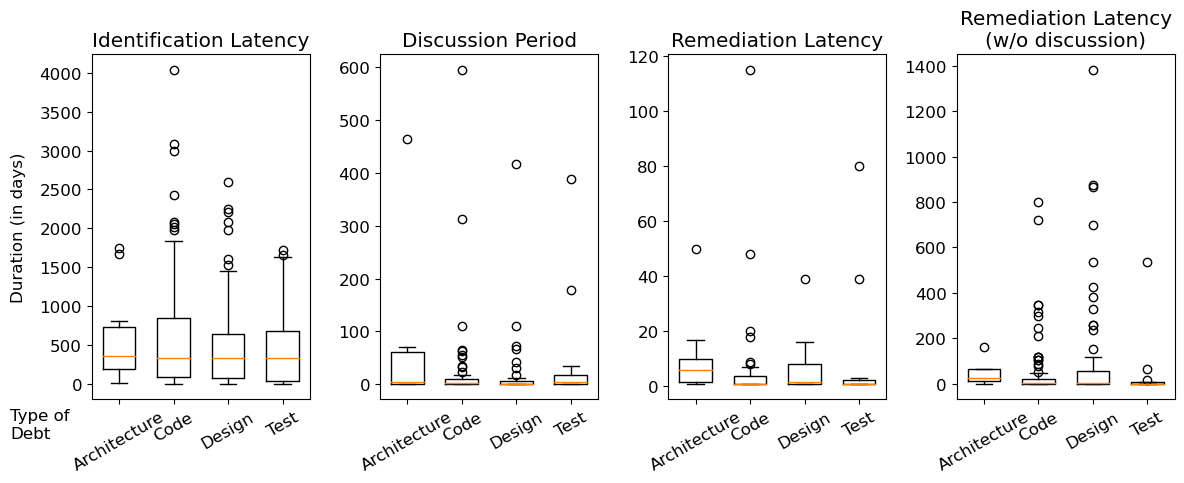

In [19]:
plt.rcParams.update({'font.size': 12})
fig, ax = plt.subplots(1,4, figsize=(12,5))
for i, col in enumerate(periods):
    data = [[int(d[col]) for d in df_rq2 if d[col] != 'unknown' and d['td_type'] == t] for t in td_types]
    ax[i].boxplot(data, widths=0.6)
    ax[i].set_xticklabels(list(td_types.values()), rotation=30)
    ax[i].set_title(periods[col])

ax[0].set_ylabel('Duration (in days)',labelpad=10)
ax[0].text(-1,-700,f'Type of\nDebt')

fig.tight_layout()
plt.show()

fig.savefig(figs_dir.joinpath("rq2-intervals-tdtypes.pdf"), bbox_inches='tight')

In [20]:
from scipy import stats

for p in periods:    
    groups = {t: [int(d[p]) for d in df_rq2 if d[p] != 'unknown' and d['td_type'] == t] for t in tdtypes}
    
    # Kruskal-Wallis
    kw_test = stats.kruskal(*groups.values())
    n = sum([len(v) for v in groups.values()]) # number of observations
    epsilon2 = kw_test.statistic/((n**2 - 1)/(n+1)) # Effect size (epsilon^2)
    print(f'{p: <40} Kruskal-Wallis (H:{kw_test.statistic:.2f} p-value:{kw_test.pvalue:.3f} eps^2:{epsilon2:.2f})')

identification_latency                   Kruskal-Wallis (H:0.39 p-value:0.943 eps^2:0.00)
discussion_period                        Kruskal-Wallis (H:2.11 p-value:0.550 eps^2:0.02)
remediation_latency                      Kruskal-Wallis (H:6.14 p-value:0.105 eps^2:0.05)
remediation_latency_without_discussion   Kruskal-Wallis (H:4.40 p-value:0.221 eps^2:0.02)


### Compare Lantencies between Projects

In [21]:
from scipy import stats

for p in periods:    
    groups = {pr: [int(d[p]) for d in df_rq2 if d[p] != 'unknown' and d['project'] == pr] for pr in projects}
    
    # Kruskal-Wallis
    kw_test = stats.kruskal(*groups.values())
    n = sum([len(v) for v in groups.values()]) # Number of observations
    epsilon2 = kw_test.statistic/((n**2 - 1)/(n+1)) # Effect size (epsilon^2)
    print(f'{p: <40} Kruskal-Wallis (H:{kw_test.statistic:.2f} p-value:{kw_test.pvalue:.3f} eps^2:{epsilon2:.2f})')

identification_latency                   Kruskal-Wallis (H:12.44 p-value:0.014 eps^2:0.04)
discussion_period                        Kruskal-Wallis (H:7.68 p-value:0.104 eps^2:0.07)
remediation_latency                      Kruskal-Wallis (H:0.89 p-value:0.926 eps^2:0.01)
remediation_latency_without_discussion   Kruskal-Wallis (H:21.98 p-value:0.000 eps^2:0.11)


## RQ3

Install necessary R packages (may take a couple of minutes)

In [22]:
%load_ext rpy2.ipython

In [23]:
from IPython.display import clear_output

%R install.packages("survminer")
%R library(survival)
%R library(survminer)
%R library(dplyr)
%R library(Hmisc)
%R library(lme4)
%R library(xtable)


clear_output(wait=False)

#### Identification latency

In [24]:
ds_rq3 = []
for d in dataset:
    if d['is_fixed'] == 'yes' and not [e for e in ds_rq3 if e['td_item'] == d['td_item']]:
        ds_rq3.append({
            'td_item': d['td_item'], 
            'identification_latency': int(d['identification_latency']),
            'is_self_identified': d['is_self_identified']
        })

save_csv_dataset(data_dir.joinpath('rq3-identification-latency.csv'), ds_rq3)

df_rq3 = dict_csv_to_dataframe(ds_rq3)

Call:
coxph(formula = Surv(identification_latency, rep(1, nrow(df_rq3))) ~ 
    is_self_identified, data = df_rq3)

  n= 312, number of events= 312 

                         coef exp(coef) se(coef)    z Pr(>|z|)    
is_self_identifiedTrue 0.8845    2.4217   0.1517 5.83 5.55e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                       exp(coef) exp(-coef) lower .95 upper .95
is_self_identifiedTrue     2.422     0.4129     1.799      3.26

Concordance= 0.569  (se = 0.012 )
Likelihood ratio test= 28.51  on 1 df,   p=9e-08
Wald test            = 33.99  on 1 df,   p=6e-09
Score (logrank) test = 36.18  on 1 df,   p=2e-09



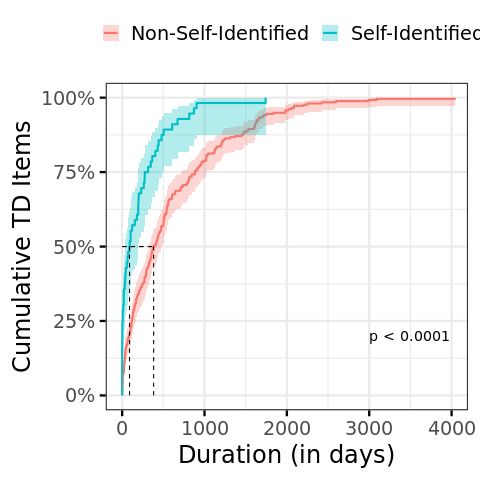

In [25]:
%%R -i df_rq3

km_fit <- survfit(Surv(identification_latency, rep(1, nrow(df_rq3))) ~ is_self_identified, data = df_rq3)
cox_fit <- coxph(Surv(identification_latency, rep(1, nrow(df_rq3))) ~ is_self_identified, data = df_rq3)

gg <- ggsurvplot(km_fit,
           conf.int = TRUE,
           pval = TRUE,
           pval.coord = c(3000, 0.2),
           break.time.by=1000,
           xlim = c(0,4000),
           fun = "event",
           risk.table = FALSE, # Show risk table under plot
           risk.table.col = "strata", # Change risk table color by groups
           risk.table.height =0.35,
           surv.scale="percent",
           surv.median.line = "hv",
           palette = c("#F8766D", "#00BFC4"),
           ylab = "Cumulative TD Items",
           xlab = "Duration (in days)",
           legend.labs = c("Non-Self-Identified","Self-Identified"),
           legend.title = "",
           ggtheme = theme_bw(base_size=24), # Change ggplot2 theme
        )

pdf("../figs/rq3-survival-identification-latency.pdf")
print(gg, newpage = FALSE)
dev.off()

# print(summary(km_fit))
# res.sum <- surv_summary(km_fit)
# head(res.sum)
print(gg)
print(summary(cox_fit))

#### Remediation latency

In [26]:
ds_rq3 = []
for d in dataset:
    if d['is_fixed'] == 'yes' and d['remediation_latency'] != 'unknown' and not [e for e in ds_rq3 if e['td_item'] == d['td_item']]:
        ds_rq3.append({
            'td_item': d['td_item'], 
            'remediation_latency': int(d['remediation_latency']),
            'is_fixer_involved_in_discussion': d['is_fixer_involved_in_discussion']
        })

save_csv_dataset(data_dir.joinpath('rq3-remediation-latency.csv'), ds_rq3)

df_rq3 = dict_csv_to_dataframe(ds_rq3)

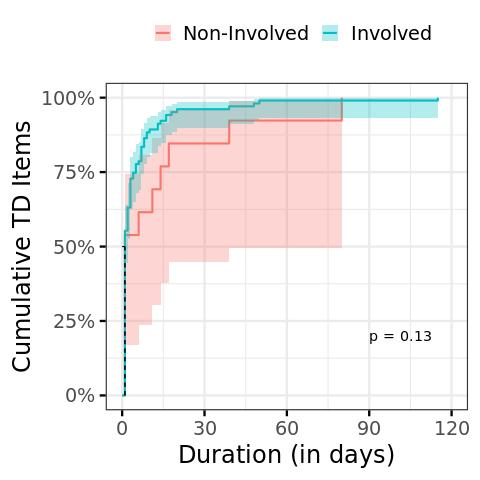

In [27]:
%%R -i df_rq3
km_fit <- survfit(Surv(remediation_latency, rep(1, nrow(df_rq3))) ~ is_fixer_involved_in_discussion, data = df_rq3)

gg <- ggsurvplot(km_fit,
           conf.int = TRUE,
           pval = TRUE,
           pval.coord = c(90, 0.2),
           break.time.by=30,
           xlim = c(0,120),
           fun = "event",
           risk.table = FALSE, # Show risk table under plot
           risk.table.col = "strata", # Change risk table color by groups
           risk.table.height =0.35,
           surv.scale="percent",
           surv.median.line = "hv",
           palette = c("#F8766D", "#00BFC4"),
           ylab = "Cumulative TD Items",
           xlab = "Duration (in days)",
           legend.labs = c("Non-Involved","Involved"),
           legend.title = "",
           ggtheme = theme_bw(base_size=24), # Change ggplot2 theme
        )

pdf("../figs/rq3-survival-remediation-latency.pdf")
print(gg, newpage = FALSE)
dev.off()

# summary(fit)
# res.sum <- surv_summary(fit)
# head(res.sum)

gg

In [28]:
ds_rq3 = []
for d in dataset:
    if d['is_fixed'] == 'yes' and d['discussion_period'] != 'unknown' and not [e for e in ds_rq3 if e['td_item'] == d['td_item']]:
        ds_rq3.append({
            'td_item': d['td_item'],
            'project': d['project'],
            'discussion_period': int(d['discussion_period']),
            'developers_in_discussion': int(d['developers_in_discussion']), 
            'introducer_in_discussion': int(d['developers_in_discussion']) != int(d['developers_in_discussion_only']),
        })

save_csv_dataset(data_dir.joinpath('rq3-discussion-period.csv'), ds_rq3)

df_rq3 = dict_csv_to_dataframe(ds_rq3)

In [29]:
%%R -i df_rq3

minMax <- function(x, ...) {
    return((x - min(x, ...)) /(max(x, ...) - min(x, ...)))
}

m=glm(discussion_period~developers_in_discussion + introducer_in_discussion, 
        data=df_rq3,
        family = 'poisson')
print(summary(m))


# Effect sizes
print("Effect Sizes")
primary <- exp(m$coefficients['(Intercept)'])

dev_discussion <- exp(m$coefficients['developers_in_discussion']+m$coefficients['(Intercept)'])
effect_size_dev_discussion <- round(((dev_discussion/primary)*100)-100,2)
print(effect_size_dev_discussion)

introducer_in_discussion <- exp(m$coefficients['introducer_in_discussionTRUE']+m$coefficients['(Intercept)'])
effect_size_introducer_in_discussion <- round(((introducer_in_discussion/primary)*100)-100,2)
print(effect_size_introducer_in_discussion)


Call:
glm(formula = discussion_period ~ developers_in_discussion + 
    introducer_in_discussion, family = "poisson", data = df_rq3)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-13.186   -7.718   -5.478   -2.795   46.981  

Coefficients:
                             Estimate Std. Error z value Pr(>|z|)    
(Intercept)                   2.54471    0.04635   54.90   <2e-16 ***
developers_in_discussion      0.33035    0.01073   30.79   <2e-16 ***
introducer_in_discussionTRUE -0.73154    0.03571  -20.49   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 12570  on 115  degrees of freedom
Residual deviance: 11359  on 113  degrees of freedom
AIC: 11748

Number of Fisher Scoring iterations: 7

[1] "Effect Sizes"
developers_in_discussion 
                   39.15 
introducer_in_discussionTRUE 
                      -51.88 


#### Remediation latency (without discussion)

In [30]:
ds_rq3 = []
for d in dataset:
    if d['is_fixed'] == 'yes' and d['remediation_latency_without_discussion'] != 'unknown' and not [e for e in ds_rq3 if e['td_item'] == d['td_item']]:
        ds_rq3.append({
            'td_item': d['td_item'], 
            'remediation_latency_without_discussion': int(d['remediation_latency_without_discussion']), 
            'is_self_resolved': d['is_self_resolved']
        })

save_csv_dataset(data_dir.joinpath('rq3-remediation-latency-without-discussion.csv'), ds_rq3)

df_rq3 = dict_csv_to_dataframe(ds_rq3)

Call:
coxph(formula = Surv(remediation_latency_without_discussion, 
    rep(1, nrow(df_rq3))) ~ is_self_resolved, data = df_rq3)

  n= 312, number of events= 312 

                       coef exp(coef) se(coef)     z Pr(>|z|)    
is_self_resolvedTrue 0.5364    1.7098   0.1177 4.556 5.22e-06 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

                     exp(coef) exp(-coef) lower .95 upper .95
is_self_resolvedTrue      1.71     0.5849     1.357     2.154

Concordance= 0.586  (se = 0.018 )
Likelihood ratio test= 20.07  on 1 df,   p=7e-06
Wald test            = 20.75  on 1 df,   p=5e-06
Score (logrank) test = 21.23  on 1 df,   p=4e-06



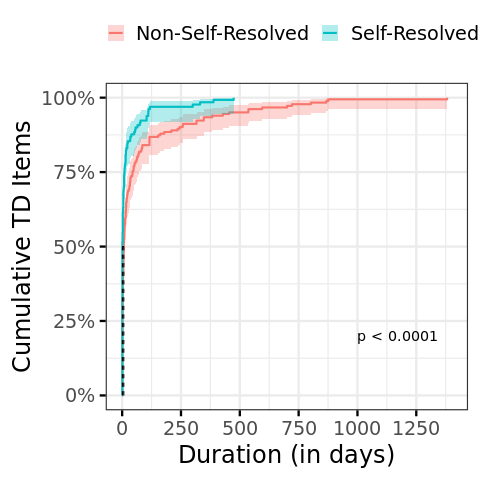

In [31]:
%%R -i df_rq3
km_fit <- survfit(Surv(remediation_latency_without_discussion, rep(1, nrow(df_rq3))) ~ is_self_resolved, data = df_rq3)
cox_fit <- coxph(Surv(remediation_latency_without_discussion, rep(1, nrow(df_rq3))) ~ is_self_resolved, data = df_rq3)

gg <- ggsurvplot(km_fit,
           conf.int = TRUE,
           pval = TRUE,
           pval.coord = c(1000, 0.2),
           break.time.by=250,
           xlim = c(0,1400),
           fun = "event",
           risk.table = FALSE, # Show risk table under plot
           risk.table.col = "strata", # Change risk table color by groups
           risk.table.height =0.35,
           surv.scale="percent",
           surv.median.line = "hv",
           palette = c("#F8766D", "#00BFC4"),
           ylab = "Cumulative TD Items",
           xlab = "Duration (in days)",
           legend.labs = c("Non-Self-Resolved","Self-Resolved"),
           legend.title = "",
           ggtheme = theme_bw(base_size=24), # Change ggplot2 theme
        )

pdf("../figs/rq3-survival-remediation-latency-wo-discussion.pdf")
print(gg, newpage = FALSE)
dev.off()

# print(summary(km_fit))
# res.sum <- surv_summary(km_fit)
# head(res.sum)
print(gg)
print(summary(cox_fit))